In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

mpl.rcParams['figure.max_open_warning'] = 10000

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# TODO
class MLP_XOR(nn.Module):
    def __init__(self, input_size, hidden_size_xor=20, output_size=1):
        super(MLP_XOR, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_xor)
        self.fc2 = nn.Linear(hidden_size_xor, hidden_size_xor)
        self.fc3 = nn.Linear(hidden_size_xor, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [16]:
#initialize

input_size = 1
hidden_size_1 = 2
hidden_size_2 = 2
output_size = 1

# TODO
hidden_size_xor = 20

In [28]:
import scipy.stats
import copy

#helper functions for MPL
def generate_data(func, low=-np.pi, high=np.pi, samples=2000):
    x = torch.linspace(low, high, samples).view(-1, 1)
    y = func(x)
    return x, y

def calc_entropy(matrix):
    EPSILON = 1e-10  # prevent log(0)
    # Flatten the matrix and normalize
    weights = copy.deepcopy(matrix).flatten()
    weights += np.abs(np.min(weights)) + EPSILON  
    weights /= (np.sum(weights) + EPSILON) 

    weights = [max(weight, EPSILON) for weight in weights]
    
    entropy = scipy.stats.entropy(weights)  # Calculate entropy
    return entropy



# TODO
def generate_xor_data(samples=2000):
    # Generate XOR data
    x = torch.randint(2, (samples, 2)).float()
    y = (x.sum(dim=1) == 1).float().view(-1, 1)
    return x, y

def train_model(model, x, y, epochs=10000):
    entropy_over_time = []
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # Calculate and store entropy of the weights
        all_weights = np.concatenate([w.detach().cpu().numpy().ravel() for w in model.parameters()])
        weights_hist, bin_edges = np.histogram(all_weights, bins=50, density=True)
        weights_entropy = scipy.stats.entropy(weights_hist)
        entropy_over_time.append(weights_entropy)

        if (epoch % 1000 == 0):
            print('Epoch {}, Loss {:.4f}, Entropy {:.4f}'.format(epoch, loss.item(), weights_entropy))

    # Plot entropy over time
    plt.figure(figsize=(10, 5))
    plt.plot(entropy_over_time, label='Entropy over time')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Entropy')
    plt.title('Entropy of weights over time during training')
    plt.grid(True)
    plt.show()

    return model

# TODO
def train_xor_model(model, x, y, epochs=20000):
    entropy_over_time = []
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # Calculate and store entropy of the weights
        all_weights = np.concatenate([w.detach().cpu().numpy().ravel() for w in model.parameters()])
        weights_hist, bin_edges = np.histogram(all_weights, bins=50, density=True)
        weights_entropy = scipy.stats.entropy(weights_hist)
        entropy_over_time.append(weights_entropy)

        if (epoch % 1000 == 0):
            print('Epoch {}, Loss {:.4f}, Entropy {:.4f}'.format(epoch, loss.item(), weights_entropy))
            
    # Plot entropy over time
    plt.figure(figsize=(10, 5))
    plt.plot(entropy_over_time, label='Entropy over time')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Entropy')
    plt.title('Entropy of weights over time during training')
    plt.grid(True)
    plt.show()

    return model

def evaluate_model(model, x, y):
    y_pred = model(x)
    mse_loss = nn.MSELoss()(y_pred, y).item()
    r2 = r2_score(y.detach().numpy(), y_pred.detach().numpy())
    print()

    print("MSE Loss: ", mse_loss)
    print("R2 Score: ", r2)

# TODO
def evaluate_xor_model(model, x, y):
    y_pred = model(x)
    y_pred = (y_pred > 0.5).float()  # Apply threshold
    correct = (y_pred == y).float().sum()  # Count correct predictions
    accuracy = correct / x.shape[0]  # Calculate accuracy
    print("Accuracy: ", accuracy.item())

def plot_predictions(func_name, model, x, y):
    y_pred = model(x)
    plt.figure(figsize=(10, 5))
    plt.plot(x.detach().numpy(), y.detach().numpy(), label='True function')
    plt.plot(x.detach().numpy(), y_pred.detach().numpy(), label='MLP predictions')
    plt.legend()
    # plt.savefig(f'{func_name}_fit.png')  # Save the plot to a file
    plt.show()

# TODO
def plot_xor_predictions(func_name, model, x, y):
    y_pred = model(x) > 0.5  # Get binary predictions
    y_pred = y_pred.detach().numpy()
    plt.figure(figsize=(10, 5))
    # Color code: 1s as red, 0s as blue
    colors = ['red' if yt == 1 else 'blue' for yt in y_pred]
    # Scatter plot with color coding
    plt.scatter(x[:, 0], x[:, 1], color=colors)
    plt.title('Predicted XOR Function')
    plt.xlabel('Input 1')
    plt.ylabel('Input 2')
    plt.grid(True)
    #plt.show()

def MLP_get_weights(model):
    weights_dict = {}
    i = 1
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            weight_matrix = layer.weight.data
            weight_matrix = weight_matrix.detach().numpy()
            weights_dict['weights_layer{}'.format(i)] = weight_matrix
            i += 1
    return weights_dict

def plot_graph_and_spectral_density(G, adj_matrix):
    # Visualize the graph
    plt.figure()
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='k')
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title('Graph with {} nodes'.format(G.number_of_nodes()), fontsize=15)
    plt.show()

    # Print the adjecent matrix
    # print(adj_matrix)

    # Perform eigendecomposition on the adjacency matrix
    eigenvalues = np.linalg.eigvalsh(adj_matrix)
    # print(eigenvalues)
    plt.scatter(eigenvalues, [0] * len(eigenvalues))
    plt.show()

    # Create a new figure for the spectral density
    plt.figure()  # Create a new figure
    print('Spectral Density')
    # Calculate the spectral density
    density, bins, _ = plt.hist(eigenvalues, bins='auto', density=True)
    plt.show()  # Show the spectral density plot

def MLP_to_non_supra_adjacency_matrix(adj_matrix):
    # get the dimensions of the adjacency matrix
    dim = adj_matrix.shape[0]

    # generate a list with the original node order
    original_order = list(range(dim))

    # create a new order by shuffling the original order
    new_order = original_order.copy()
    random.shuffle(new_order)

    # create a new adjacency matrix with the new order
    shuffled_adj_matrix = adj_matrix[:, new_order][new_order]

    # Create graph from shuffled adjacency matrix
    G = nx.from_numpy_array(shuffled_adj_matrix, create_using=nx.DiGraph)

    # Add weights to the edges
    for i, j in G.edges():
        G[i][j]['weight'] = shuffled_adj_matrix[i, j]

    print('Undirected Non-Supra Adjacency Matrix')
    plot_graph_and_spectral_density(G, shuffled_adj_matrix)


def MLP_to_supra_adjacency_matrix(model):

    weights = MLP_get_weights(model)
    # Original Weights
    # weights_layer1 = weights['weights_layer1']
    # weights_layer2 = weights['weights_layer2']
    # weights_layer3 = weights['weights_layer3']

    # Convert the weights from floating numbers to strings to beautify the matrices and graphs
    weights_layer1 = np.round(weights['weights_layer1'], 2).astype(str)
    weights_layer2 = np.round(weights['weights_layer2'], 2).astype(str)
    weights_layer3 = np.round(weights['weights_layer3'], 2).astype(str)

    # print(weights_layer1)
    # print(weights_layer2)
    # print(weights_layer3)

    # Create a directed graph
    G = nx.DiGraph()

    # Add input node to the graph
    G.add_node(0)

    # Iterate through the weights and add each node and edge to the graph
    for i, weight in enumerate(weights_layer1, start=1):
        G.add_node(i)
        G.add_edge(0, i, weight=float(weight))

    # Get the number of nodes in the graph so far
    num_nodes = G.number_of_nodes()
    # Iterate through the weights of the second layer and add each node and edge to the graph
    for i, row_weights in enumerate(weights_layer2, start=1):
        for j, weight in enumerate(row_weights, start=num_nodes):
            if not G.has_node(j):
                G.add_node(j)
            G.add_edge(i, j, weight=float(weight))

    # Get the number of nodes in the graph so far
    num_nodes = G.number_of_nodes()

    # Add the last node for the third layer
    G.add_node(num_nodes)

    # Iterate through the weights of the third layer and add each edge to the graph
    for i, weight in enumerate(weights_layer3[0], start=num_nodes - weights_layer3.shape[1]):
        G.add_edge(i, num_nodes, weight=float(weight))

    # Convert the graph to undirected
    G = G.to_undirected()
    # Convert the graph to an adjacency matrix
    adj_matrix = nx.to_numpy_array(G)

    print('Undirected Supra Adjacency Matrix')
    plot_graph_and_spectral_density(G, adj_matrix)

    # Print the non-supra Adjacency matrix
    MLP_to_non_supra_adjacency_matrix(adj_matrix)

def MLP_matrix_representation(model):
    matrix_representation = []
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            weight_matrix = layer.weight.data
            # Converting the tensor to numpy array
            weight_matrix = weight_matrix.detach().numpy()
            matrix_representation.append(weight_matrix)
    return matrix_representation

def print_and_save_heatmap(matrices, suffix):
    for i, matrix in enumerate(matrices):
        print(f"Matrix for layer {i+1}:")
        print()  # Add a line break for readability

        plt.figure(figsize=(8, 8))
        sns.heatmap(matrix, cmap='coolwarm', center=0)
        plt.title(f'{suffix}_Adjacency Matrix for Layer {i+1}')
        plt.savefig(f'{suffix}_layer_{i+1}_adjacency_matrix.png')  # Save the plot to a file
        plt.show()  # Change this line

def run_experiment(func_name, func, model_class=MLP, epochs=10000, low=-np.pi, high=np.pi):
    x, y = generate_data(func, low, high)
    pre_train_model = model_class()

    # Print and plot adjacency matrices before training
    print('Before Training:')
    MLP_to_supra_adjacency_matrix(pre_train_model)

    # Print and plot_matrices
    # adjacency_matrix_before = MLP_matrix_representation(pre_train_model)
    # print_and_save_heatmap(adjacency_matrix_before, f'{func_name}_before')

    # Train the model
    trained_model = train_model(pre_train_model, x, y, epochs)

    # Print and plot adjacency matrices after training
    print('After Training:')
    MLP_to_supra_adjacency_matrix(trained_model)

    # Print and plot_matrices
    # adjacency_matrix_after = MLP_matrix_representation(trained_model)
    # print_and_save_heatmap(adjacency_matrix_after, f'{func_name}_after')

    # Evaluate the model and plot the predictions
    evaluate_model(trained_model, x, y)
    plot_predictions(func_name, trained_model, x, y)

    # Return the models before and after training
    return pre_train_model, trained_model

# TODO
def run_experiment_xor(func_name, model_class=MLP_XOR, epochs=20000):
    x, y = generate_xor_data()
    model = model_class(input_size=2)

    # Print and plot adjacency matrices before training
    print('Before Training:')
    matrix = MLP_to_supra_adjacency_matrix(model)
    print_and_save_heatmap(matrix, f'{func_name}_before')

    # Train the model
    model = train_model(model, x, y, epochs)

    # Print and plot adjacency matrices after training
    print('After Training:')
    matrix = MLP_to_supra_adjacency_matrix(model)
    print_and_save_heatmap(matrix, f'{func_name}_after')

    # Evaluate the model and plot the predictions
    evaluate_xor_model(model, x, y)
    plot_xor_predictions(func_name, model, x, y)

# Call the function and get both models
# pre_train_sin_model, trained_sin_model = run_experiment("Sin", torch.sin)

# # Save the models
# torch.save(pre_train_sin_model.state_dict(), 'pre_train_sin_model.pth')
# torch.save(trained_sin_model.state_dict(), 'trained_sin_model.pth')


--- Sin Function ---
Before Training:
Undirected Supra Adjacency Matrix


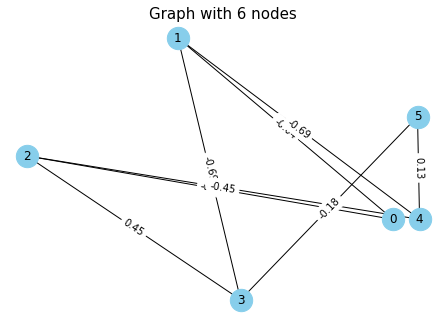

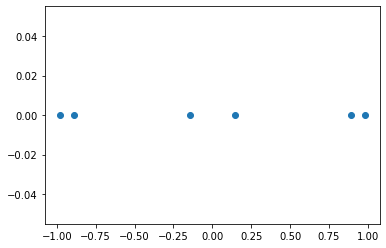

Spectral Density


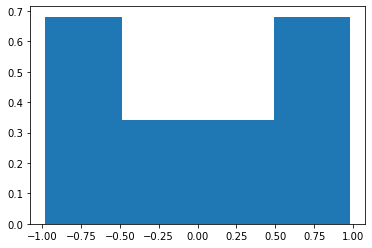

Undirected Non-Supra Adjacency Matrix


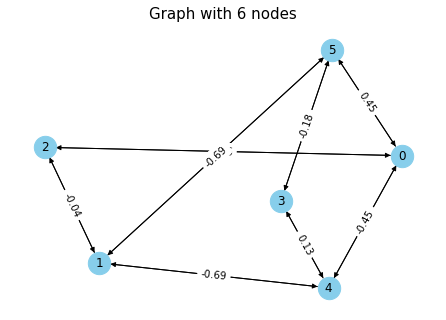

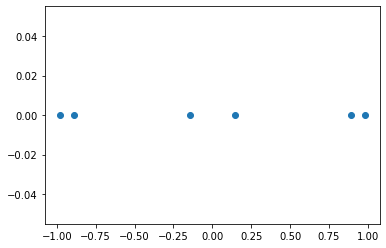

Spectral Density


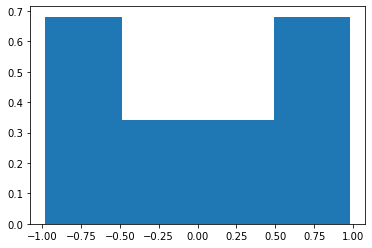

Epoch 0, Loss 0.7292, Entropy 0.1191
Epoch 1000, Loss 0.0616, Entropy 0.3124
Epoch 2000, Loss 0.0612, Entropy 0.3108
Epoch 3000, Loss 0.0611, Entropy 0.3100
Epoch 4000, Loss 0.0611, Entropy 0.3097
Epoch 5000, Loss 0.0611, Entropy 0.3095
Epoch 6000, Loss 0.0611, Entropy 0.3094
Epoch 7000, Loss 0.0611, Entropy 0.3093
Epoch 8000, Loss 0.0611, Entropy 0.3092
Epoch 9000, Loss 0.0611, Entropy 0.3092


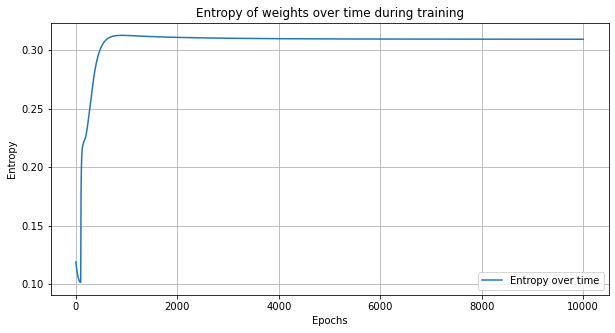

After Training:
Undirected Supra Adjacency Matrix


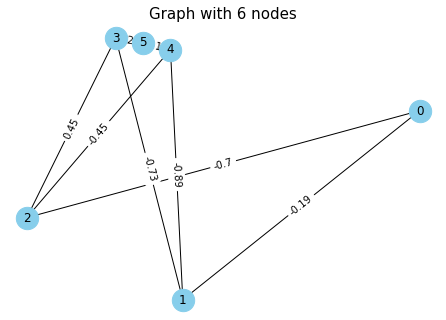

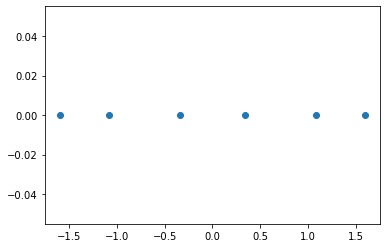

Spectral Density


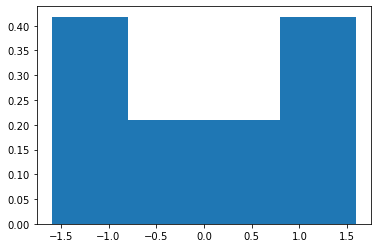

Undirected Non-Supra Adjacency Matrix


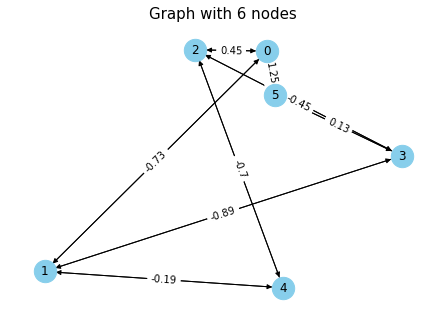

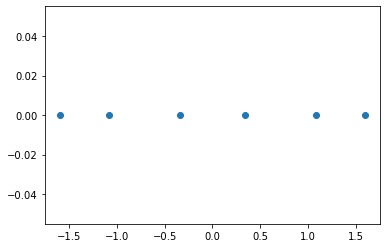

Spectral Density


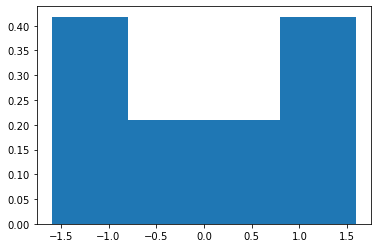


MSE Loss:  0.0611451119184494
R2 Score:  0.8776485907278756


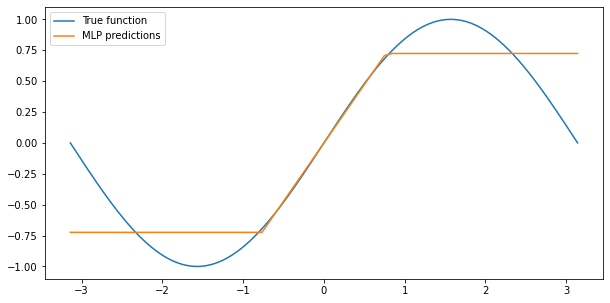


--- Cos Function ---
Before Training:
Undirected Supra Adjacency Matrix


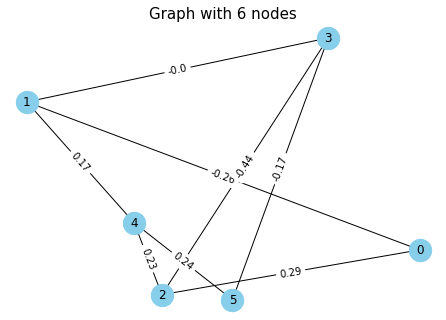

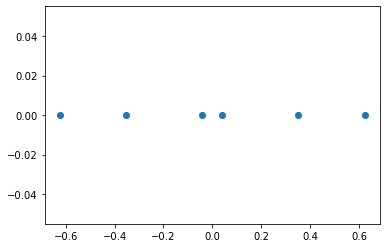

Spectral Density


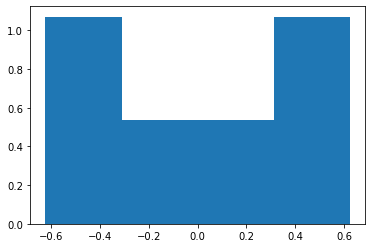

Undirected Non-Supra Adjacency Matrix


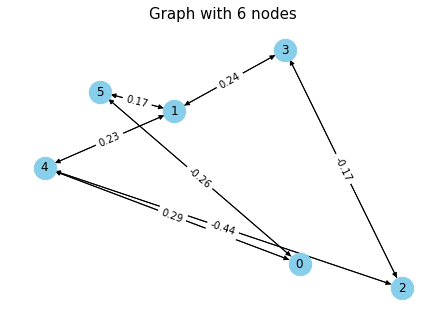

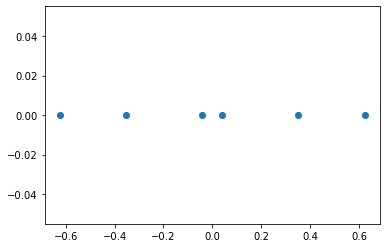

Spectral Density


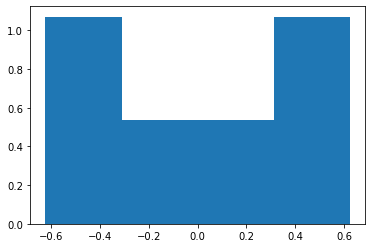

Epoch 0, Loss 0.6087, Entropy 0.2960
Epoch 1000, Loss 0.3616, Entropy 0.2929
Epoch 2000, Loss 0.0054, Entropy 0.1762
Epoch 3000, Loss 0.0047, Entropy 0.1767
Epoch 4000, Loss 0.0045, Entropy 0.1770
Epoch 5000, Loss 0.0044, Entropy 0.1771
Epoch 6000, Loss 0.0044, Entropy 0.1773
Epoch 7000, Loss 0.0043, Entropy 0.1774
Epoch 8000, Loss 0.0043, Entropy 0.1776
Epoch 9000, Loss 0.0042, Entropy 0.1777


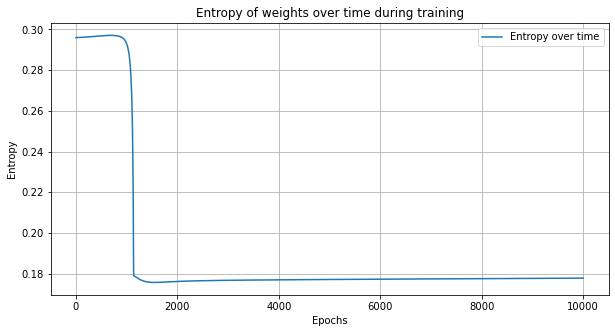

After Training:
Undirected Supra Adjacency Matrix


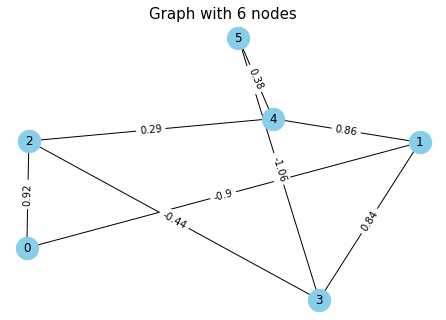

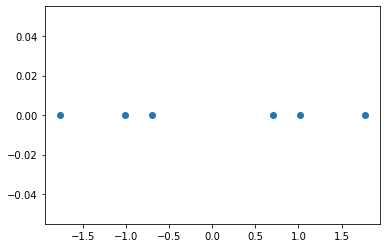

Spectral Density


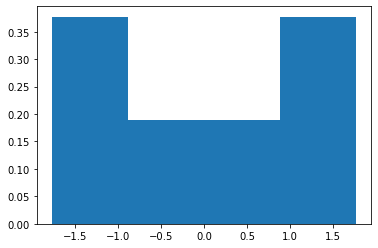

Undirected Non-Supra Adjacency Matrix


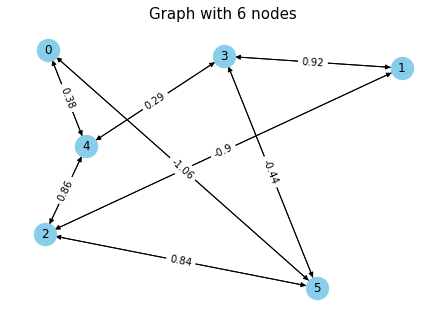

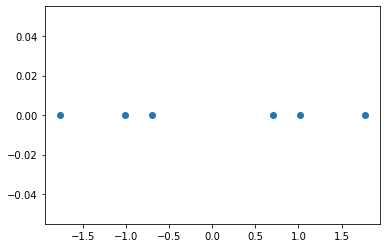

Spectral Density


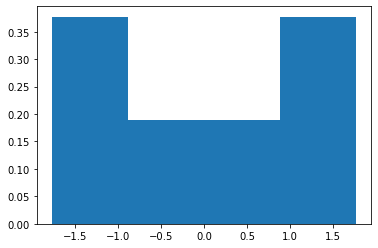


MSE Loss:  0.004194085486233234
R2 Score:  0.9916160166067276


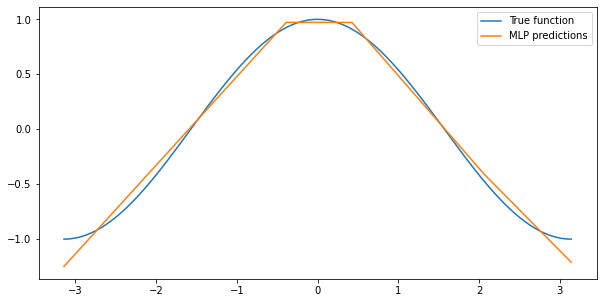


--- Exp Function ---
Before Training:
Undirected Supra Adjacency Matrix


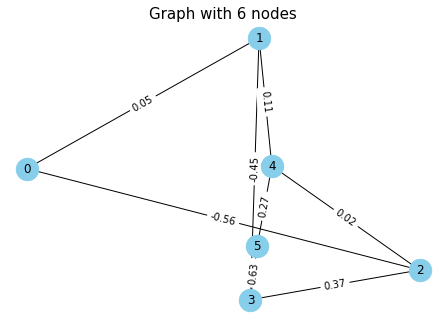

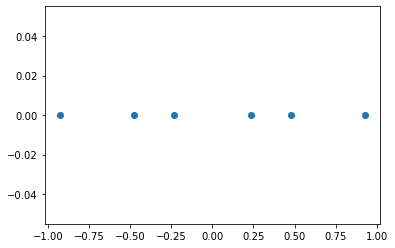

Spectral Density


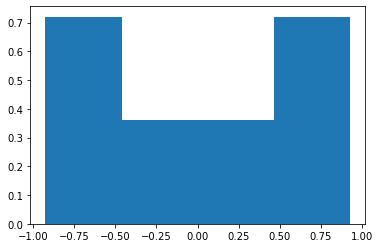

Undirected Non-Supra Adjacency Matrix


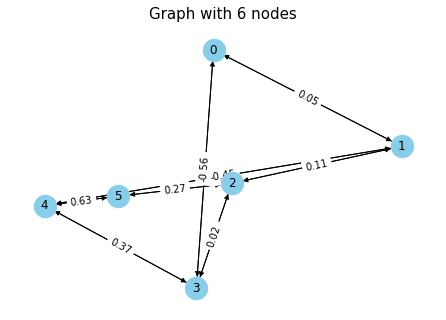

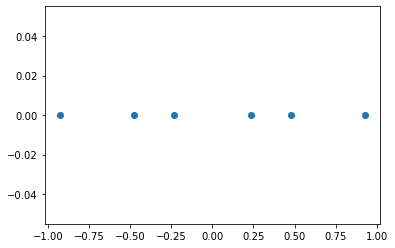

Spectral Density


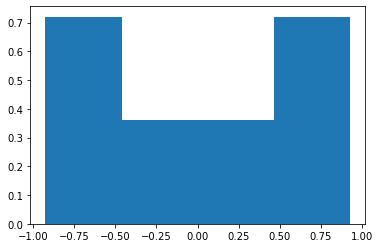

Epoch 0, Loss 1.0624, Entropy 0.3893
Epoch 1000, Loss 0.4329, Entropy 0.3910
Epoch 2000, Loss 0.4329, Entropy 0.3910
Epoch 3000, Loss 0.4329, Entropy 0.3910
Epoch 4000, Loss 0.4329, Entropy 0.3910
Epoch 5000, Loss 0.4329, Entropy 0.3910
Epoch 6000, Loss 0.4329, Entropy 0.3910
Epoch 7000, Loss 0.4329, Entropy 0.3910
Epoch 8000, Loss 0.4329, Entropy 0.3910
Epoch 9000, Loss 0.4329, Entropy 0.3910


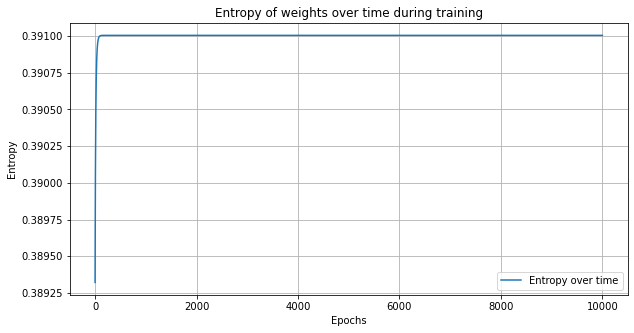

After Training:
Undirected Supra Adjacency Matrix


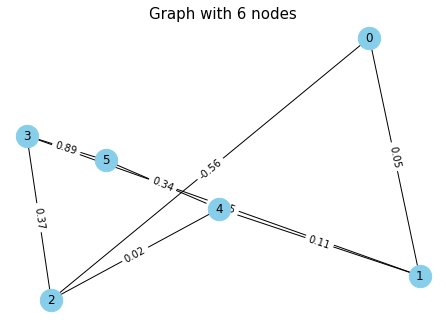

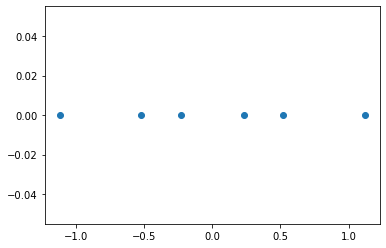

Spectral Density


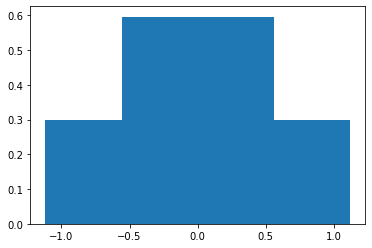

Undirected Non-Supra Adjacency Matrix


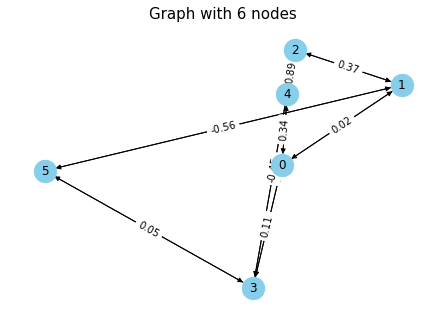

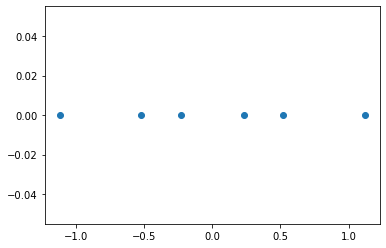

Spectral Density


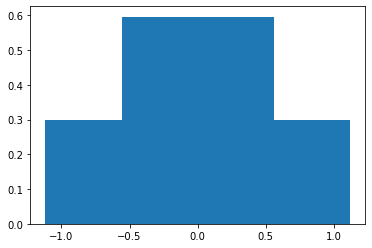


MSE Loss:  0.43287476897239685
R2 Score:  1.1869232263705953e-09


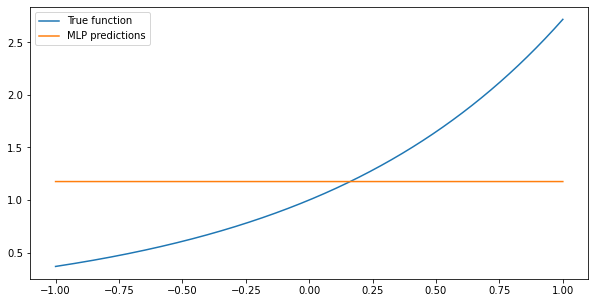


--- Polynomial Function ---
Before Training:
Undirected Supra Adjacency Matrix


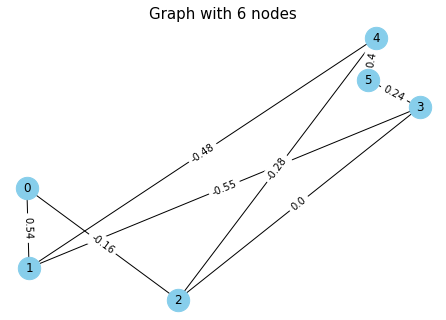

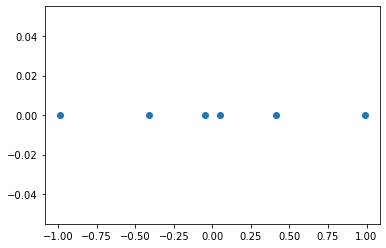

Spectral Density


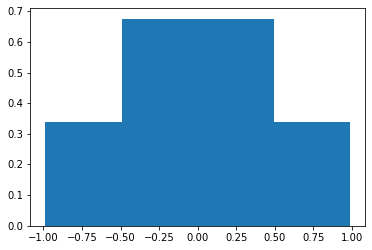

Undirected Non-Supra Adjacency Matrix


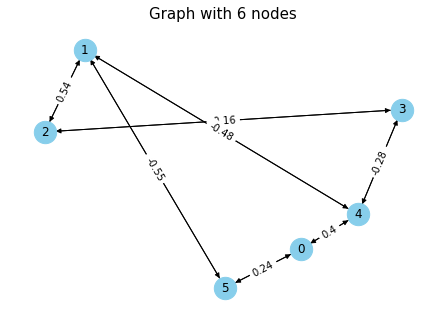

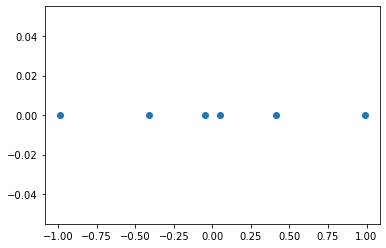

Spectral Density


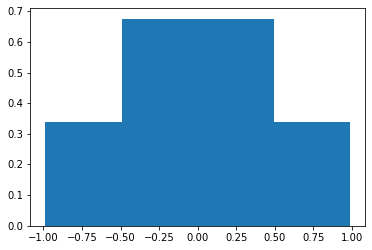

Epoch 0, Loss 0.1342, Entropy 0.3569
Epoch 1000, Loss 0.0293, Entropy 0.3628
Epoch 2000, Loss 0.0247, Entropy 0.3934
Epoch 3000, Loss 0.0121, Entropy 0.3993
Epoch 4000, Loss 0.0068, Entropy 0.4470
Epoch 5000, Loss 0.0048, Entropy 0.4549
Epoch 6000, Loss 0.0039, Entropy 0.4573
Epoch 7000, Loss 0.0035, Entropy 0.4583
Epoch 8000, Loss 0.0033, Entropy 0.4587
Epoch 9000, Loss 0.0032, Entropy 0.4589


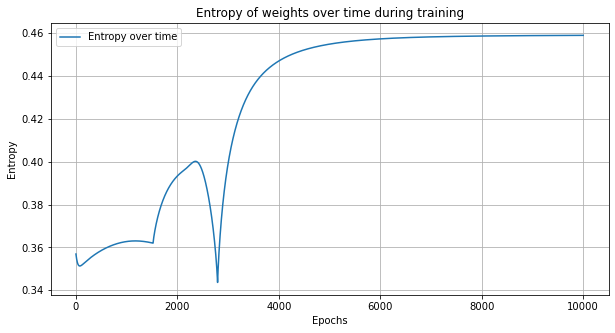

After Training:
Undirected Supra Adjacency Matrix


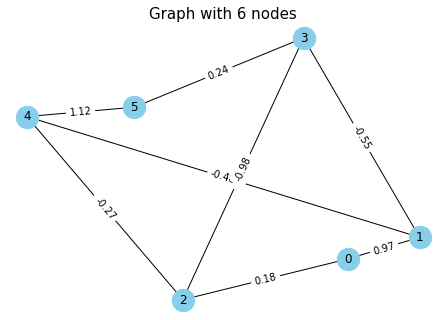

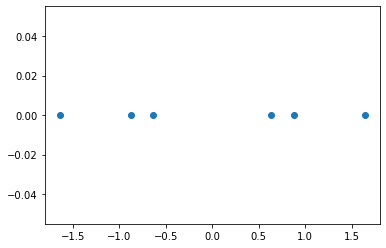

Spectral Density


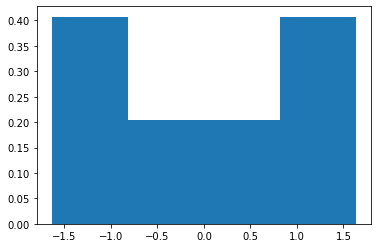

Undirected Non-Supra Adjacency Matrix


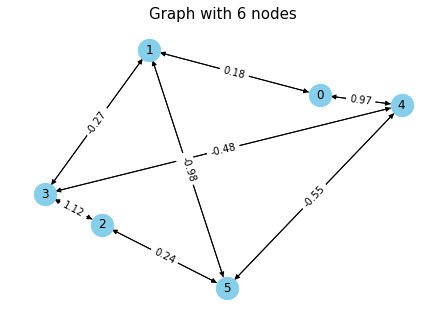

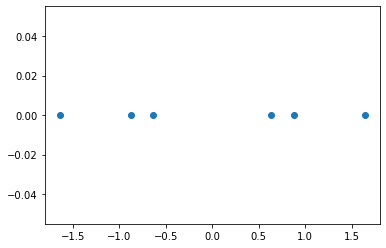

Spectral Density


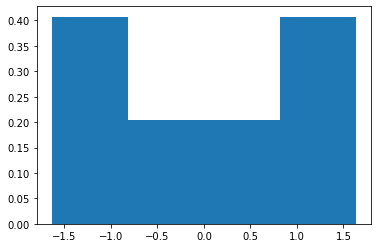


MSE Loss:  0.0031962143257260323
R2 Score:  0.9091015044307242


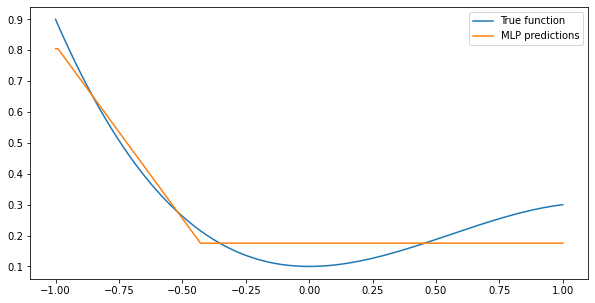


--- Square Root Function ---
Before Training:
Undirected Supra Adjacency Matrix


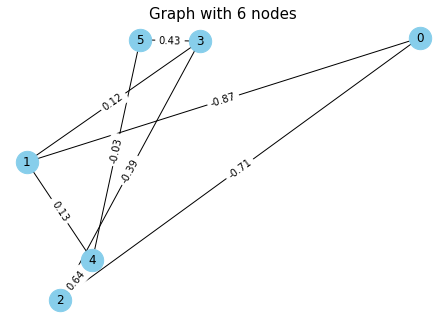

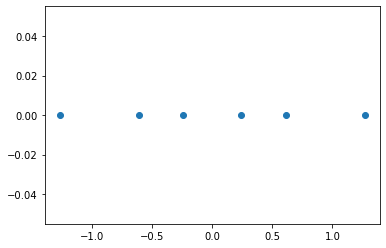

Spectral Density


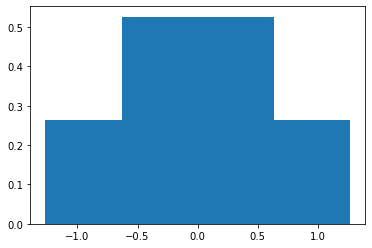

Undirected Non-Supra Adjacency Matrix


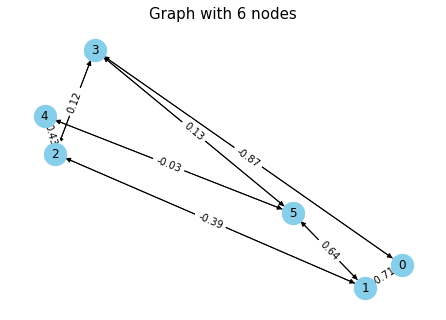

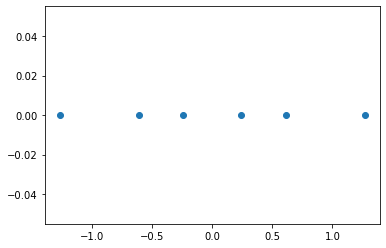

Spectral Density


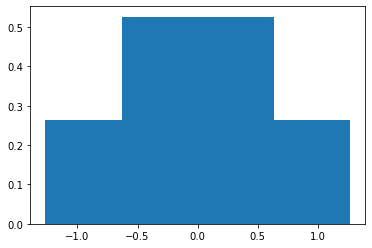

Epoch 0, Loss 0.7229, Entropy 0.1732
Epoch 1000, Loss 0.0162, Entropy 0.2926
Epoch 2000, Loss 0.0030, Entropy 0.2914
Epoch 3000, Loss 0.0015, Entropy 0.2908
Epoch 4000, Loss 0.0013, Entropy 0.2906
Epoch 5000, Loss 0.0013, Entropy 0.2905
Epoch 6000, Loss 0.0013, Entropy 0.2905
Epoch 7000, Loss 0.0013, Entropy 0.2905
Epoch 8000, Loss 0.0013, Entropy 0.2905
Epoch 9000, Loss 0.0013, Entropy 0.2905


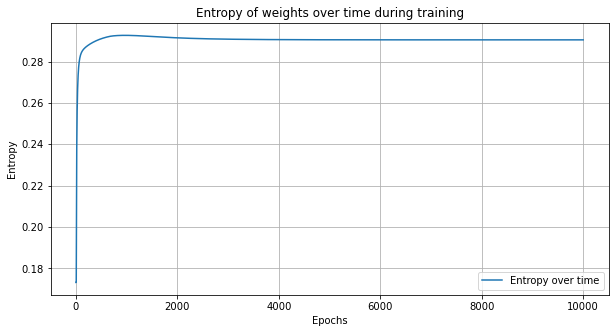

After Training:
Undirected Supra Adjacency Matrix


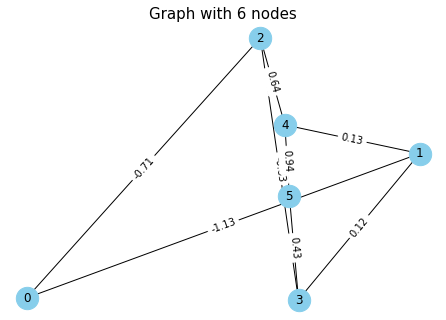

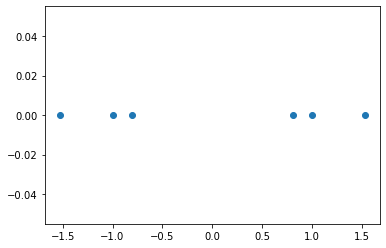

Spectral Density


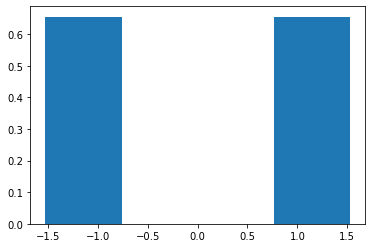

Undirected Non-Supra Adjacency Matrix


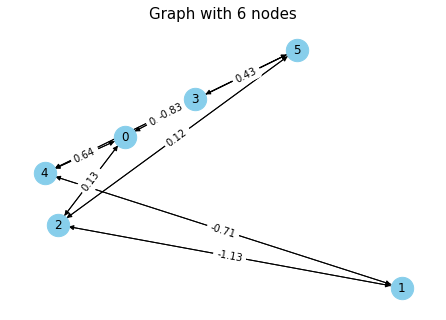

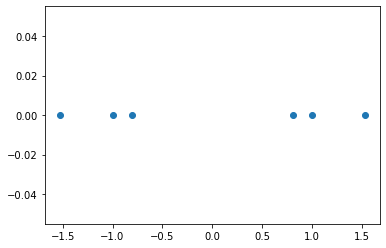

Spectral Density


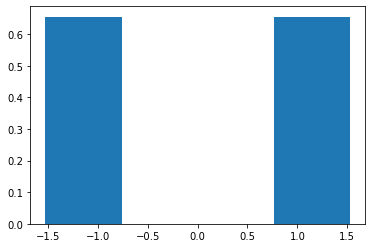


MSE Loss:  0.0012951837852597237
R2 Score:  0.9753395560911242


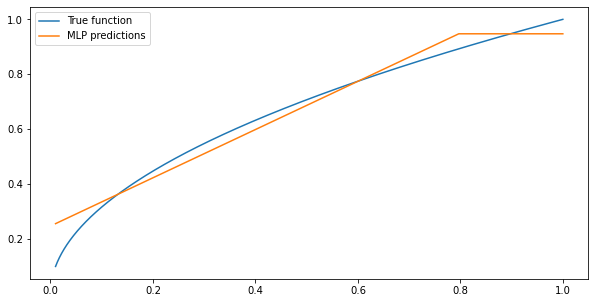


--- Gaussian Function ---
Before Training:
Undirected Supra Adjacency Matrix


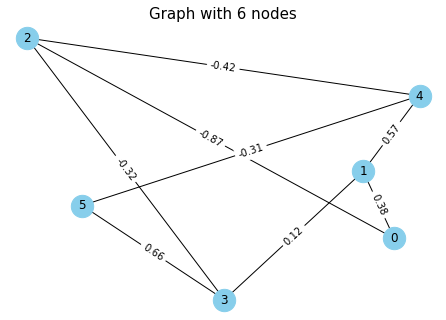

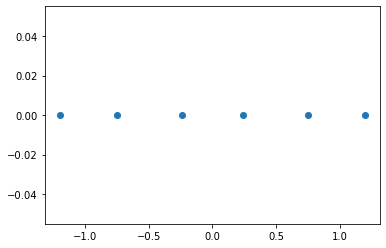

Spectral Density


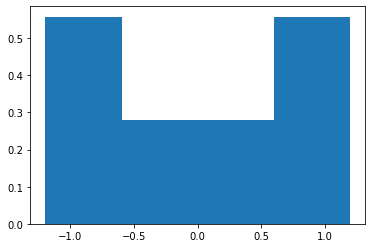

Undirected Non-Supra Adjacency Matrix


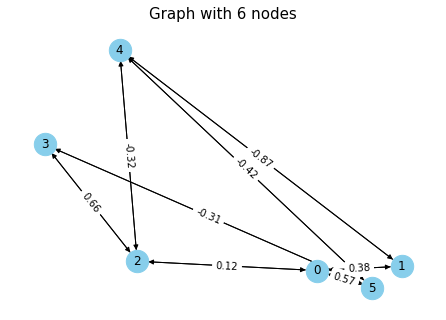

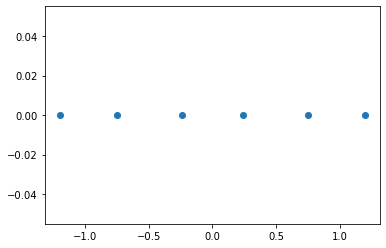

Spectral Density


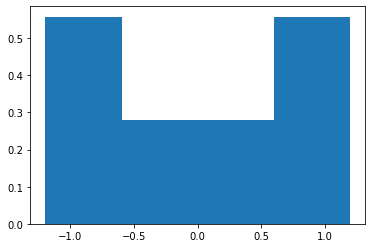

Epoch 0, Loss 1.2691, Entropy 0.2481
Epoch 1000, Loss 0.1200, Entropy 0.2609
Epoch 2000, Loss 0.1188, Entropy 0.2613
Epoch 3000, Loss 0.1188, Entropy 0.2614
Epoch 4000, Loss 0.1188, Entropy 0.2614
Epoch 5000, Loss 0.1188, Entropy 0.2614
Epoch 6000, Loss 0.1188, Entropy 0.2614
Epoch 7000, Loss 0.1188, Entropy 0.2614
Epoch 8000, Loss 0.1188, Entropy 0.2614
Epoch 9000, Loss 0.1188, Entropy 0.2614


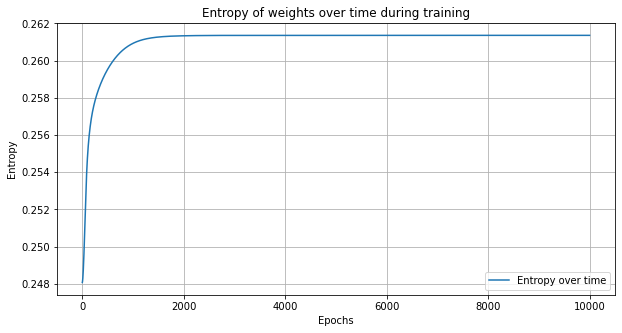

After Training:
Undirected Supra Adjacency Matrix


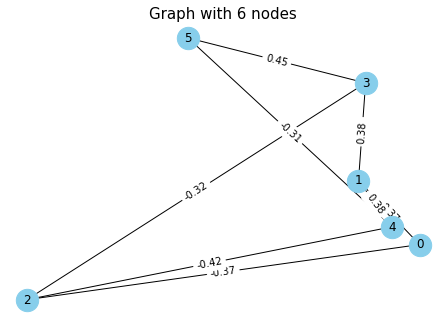

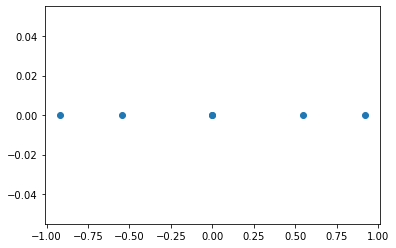

Spectral Density


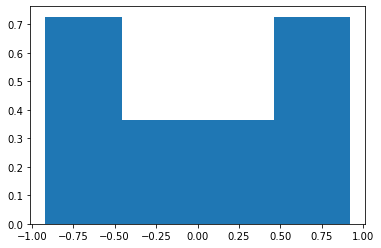

Undirected Non-Supra Adjacency Matrix


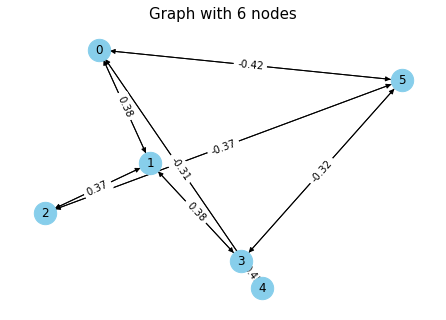

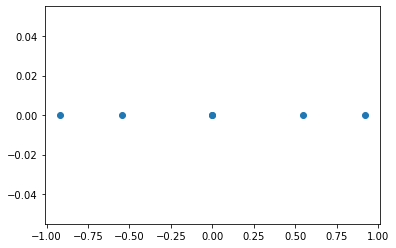

Spectral Density


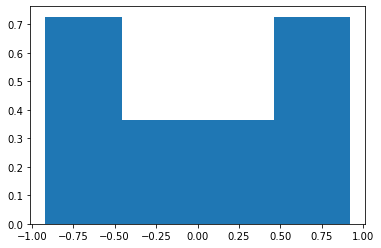


MSE Loss:  0.11882171779870987
R2 Score:  3.1264170141653835e-09


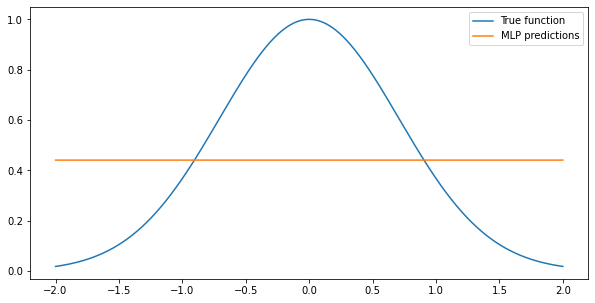

(MLP(
   (fc1): Linear(in_features=1, out_features=2, bias=True)
   (fc2): Linear(in_features=2, out_features=2, bias=True)
   (fc3): Linear(in_features=2, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=1, out_features=2, bias=True)
   (fc2): Linear(in_features=2, out_features=2, bias=True)
   (fc3): Linear(in_features=2, out_features=1, bias=True)
   (relu): ReLU()
 ))

In [29]:
# Test the function with different functions
print("\n--- Sin Function ---")
run_experiment("Sin", torch.sin)

print("\n--- Cos Function ---")
run_experiment("Cos", torch.cos)

print("\n--- Exp Function ---")
run_experiment("Exp", torch.exp, low=-1, high=1)

print("\n--- Polynomial Function ---")
run_experiment("Polynomial", lambda x: 0.5*x**2 - 0.3*x**3 + 0.1, low=-1, high=1)

print("\n--- Square Root Function ---")
run_experiment("Square_Root", torch.sqrt, low=0.01, high=1)

print("\n--- Gaussian Function ---")
run_experiment("Gaussian", lambda x: torch.exp(-x**2), low=-2, high=2)